### **Problem Statement**


- Predicting student performance (Pass/Fail) based on student background and parental education.

#### **Why?**
- Improved predictions can help target students who need additional support


**Import Libraries**

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [17]:
# # mac
# data = pd.read_csv('/Users/azel/Documents/GitHub/Azel-s-DAC-Curriculum/Internal-Project/Students_Performance.csv') 

#windows
data = pd.read_csv('C:/Users/azelt/OneDrive/Documents/GitHub/Azel-s-DAC-Curriculum/Internal-Project/Students_Performance.csv') 

### **Average, Grade, and Status Columns**

In [18]:
# average score
data['average score'] = (data['math score'] + data['reading score'] + data['writing score']) / 3

# grade system
def grade_system(score):
    if score >= 70: return "First Class Honours"
    elif score >= 60: return "Second Upper Class Honours"
    elif score >= 50: return "Second Lower Class Honours"
    elif score >= 40: return "Third Class Honours"
    else: return "Fail"

data['grade'] = data['average score'].apply(grade_system)

In [19]:
# set Second Upper Class Honours as "Pass"
data['status'] = data['average score'].apply(lambda x: 'Fail' if x < 60 else 'Pass')

### **Check Class Distribution**

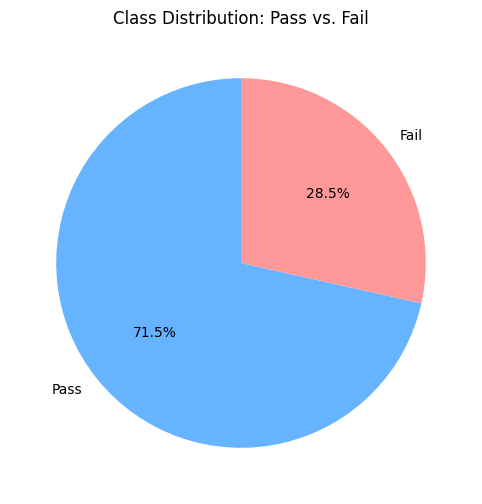

In [20]:
# counts the occurrences of each class in 'status' column (Pass/Fail)
class_counts = data['status'].value_counts()

# define labels and sizes for the pie chart
labels = class_counts.index
sizes = class_counts.values

# create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution: Pass vs. Fail')
plt.show()

#### **Observation**:
The dataset is imbalanced, with 71.5% of students labeled as 'Pass' and only 28.5% labeled as 'Fail.

#### **Implications**:
- This imbalance could bias the model towards predicting the majority class ('Pass') more often, leading to poor performance in identifying the minority class ('Fail').
- Class imbalance is particularly problematic in this case as the minority class ('Fail') is critical to identify.

### **Pre-process the Data**

In [21]:
ml_data = data.copy()

In [22]:
ml_data.drop(columns=["math score", "reading score", "writing score", "grade", "average score"], inplace=True)
ml_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,status
0,female,group B,bachelor's degree,standard,none,Pass
1,female,group C,some college,standard,completed,Pass
2,female,group B,master's degree,standard,none,Pass
3,male,group A,associate's degree,free/reduced,none,Fail
4,male,group C,some college,standard,none,Pass


In [23]:
categorical_features = ['gender', 'race/ethnicity', 'lunch', 'test preparation course', 'status']
ml_data_encoded = pd.get_dummies(ml_data, columns=categorical_features, drop_first=True)

In [24]:
ml_data_encoded.head()


,parental level of education,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_standard,test preparation course_none,status_Pass
0,bachelor's degree,False,True,False,False,False,True,True,True
1,some college,False,False,True,False,False,True,False,True
2,master's degree,False,True,False,False,False,True,True,True
3,associate's degree,True,False,False,False,False,False,True,False
4,some college,True,False,True,False,False,True,True,True


In [25]:
# define the order of categories for the 'parental level of education' column
education_order = [[
    "some high school", # 0
    "high school",      # 1
    "some college",     # 2
    "associate's degree", # 3
    "bachelor's degree",  # 4
    "master's degree",    # 5
]]

#ordinal encoder encodes categorical data into integers while preserving a specified order.
ordinal_encoder = OrdinalEncoder(categories=education_order)

ml_data_encoded["parental level of education"] = ordinal_encoder.fit_transform(ml_data_encoded[["parental level of education"]])


In [26]:
ml_data_encoded.head()

,parental level of education,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_standard,test preparation course_none,status_Pass
0,4.0,False,True,False,False,False,True,True,True
1,2.0,False,False,True,False,False,True,False,True
2,5.0,False,True,False,False,False,True,True,True
3,3.0,True,False,False,False,False,False,True,False
4,2.0,True,False,True,False,False,True,True,True


### ***Define Features & Target Variables***

In [27]:
# define the features and target variable
X = ml_data_encoded.drop(columns = ["status_Pass"])
y = ml_data_encoded["status_Pass"]

# split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

logreg = LogisticRegression(random_state=42)
logreg_cv = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

# Check the Best Parameters and Best Score
print("Best Parameters: " + str(logreg_cv.best_params_))
print("Best Score: " + str(logreg_cv.best_score_)) # best cross-validated accuracy score

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.7575


In [29]:
# the accuracy of the model on the training data.
logreg_training_accuracy = logreg_cv.score(X_train, y_train)
# the accuracy of the model on the testing data
logreg_test_accuracy = logreg_cv.score(X_test, y_test)

print(f"Training Accuracy: {logreg_training_accuracy}")
print(f"Test Accuracy: {logreg_test_accuracy}")

Training Accuracy: 0.75625
Test Accuracy: 0.68


Confusion Matrix:
[[  7  50]
 [ 14 129]]


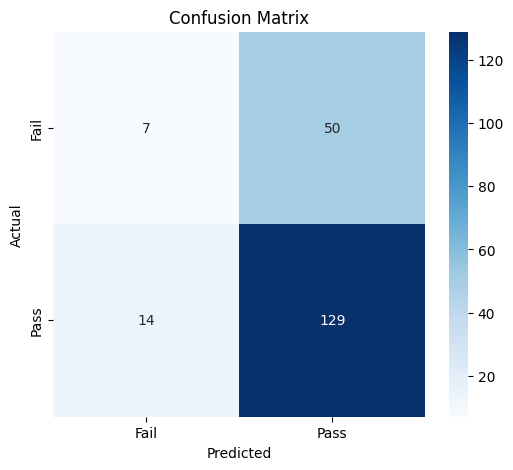

Classification Report:
              precision    recall  f1-score   support

       False       0.33      0.12      0.18        57
        True       0.72      0.90      0.80       143

    accuracy                           0.68       200
   macro avg       0.53      0.51      0.49       200
weighted avg       0.61      0.68      0.62       200



In [30]:
# Predict on test data
y_pred = logreg_cv.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


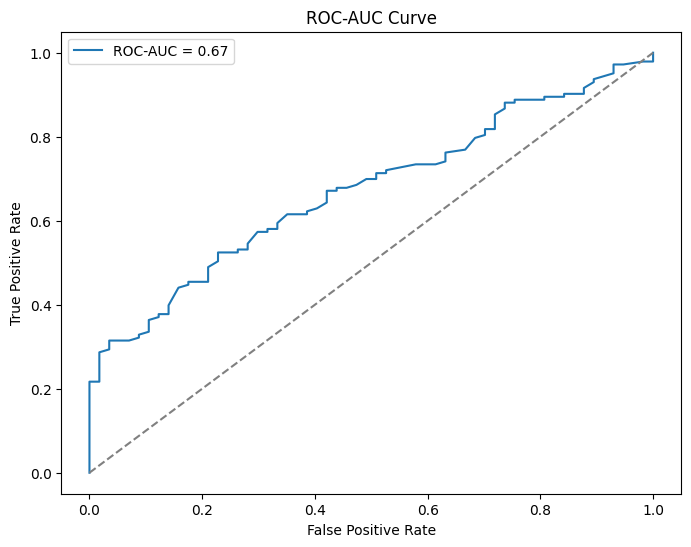

In [31]:
# Predict probabilities
y_prob = logreg_cv.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

### ***What This Graph Tells Us***

- The current model has moderate performance at distinguishing between "Pass" or "Fail"
- The curve is not very far above the diagonal, which indicates the model struggles slightly to identify some positives or negatives correctly.